<a href="https://colab.research.google.com/github/peytonrunyan/DS-Sprint-01-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=89.20789807548368, mobile=True), User(purchased=False, time_on_site=30.86107865275674, mobile=True), User(purchased=False, time_on_site=51.09325922360149, mobile=True), User(purchased=False, time_on_site=194.83050486270517, mobile=True), User(purchased=False, time_on_site=6.889954498474403, mobile=True), User(purchased=False, time_on_site=252.03464080497508, mobile=True), User(purchased=False, time_on_site=5.599939725834057, mobile=True), User(purchased=False, time_on_site=280.3252426108601, mobile=True), User(purchased=True, time_on_site=110.19070804590947, mobile=True), User(purchased=False, time_on_site=164.1491940984587, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,89.207898,True
1,False,30.861079,True
2,False,51.093259,True
3,False,194.830505,True
4,False,6.889954,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.556386337924775,5.599939725834057,5.931549947003351,6.168209547112026,6.55207159312958,6.889954498474403,7.045222548322763,7.424868997441668,8.168369859117925,8.509945906175366,...,573.8599463676945,575.255787333133,577.7081327992973,577.944356506638,586.6210234530696,587.9260747764205,590.2268765680874,595.5172402973,599.1047294738047,599.1580574247225
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.963, 124.277]","(124.277, 242.997]","(242.997, 361.717]","(361.717, 480.438]","(480.438, 599.158]"
purchased,,,,,
False,285,295,149,34,53
True,60,75,37,8,4


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.963, 124.277]","(124.277, 242.997]","(242.997, 361.717]","(361.717, 480.438]","(480.438, 599.158]"
purchased,,,,,
False,0.826087,0.797297,0.801075,0.809524,0.929825
True,0.173913,0.202703,0.198925,0.190476,0.070175


In [9]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.908,0.785333
True,0.092,0.214667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
#pd.crosstab(user_data['purchased'], user_data['time_on_site'])
df = pd.read_csv('https://github.com/peytonrunyan/DS-Sprint-01-Dealing-With-Data/raw/master/module4-databackedassertions/persons.csv')

In [14]:
df.head(5)

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


(17.999, 30.0]    256
(30.0, 42.0]      253
(42.0, 54.0]      199
(54.0, 68.0]      266
Name: age, dtype: int64


[Text(0,0,'18 to 30.'),
 Text(0,0,'30 to 42'),
 Text(0,0,'42 to 54'),
 Text(0,0,'54 to 68')]

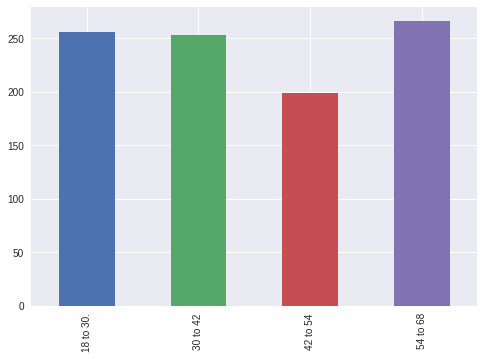

In [79]:
#help(pd.cut)
age_bins = pd.cut(df['age'],bins=[18, 30, 42, 54, 68],include_lowest=True)
age_bins
import matplotlib.pyplot as plt
#dir(plt)
#help(plt.bar)
abvc = age_bins.value_counts(sort=False)
print(abvc)
#type(abvc)
ax =abvc.plot.bar()
ax.set_xticklabels(['18 to 30.', '30 to 42', '42 to 54', '54 to 68'])


In [0]:
#pd.crosstab(user_data['purchased'], user_data['time_on_site'])
weight_bins = pd.cut(df['weight'], 5, include_lowest=True)
crosstab= pd.crosstab(age_bins, weight_bins)

In [0]:
import seaborn as sns

In [0]:
!pip install seaborn --upgrade


In [0]:
dir(sns)

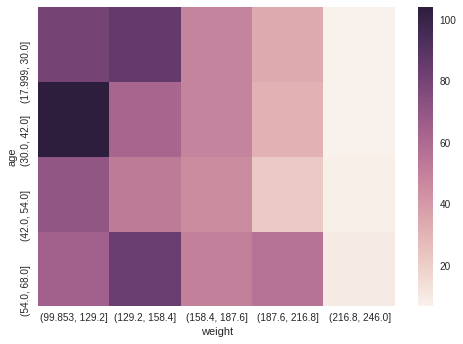

In [73]:
sns.heatmap(crosstab)
#dir(sns)

In [83]:
list(df)

['Unnamed: 0', 'age', 'weight', 'exercise_time']

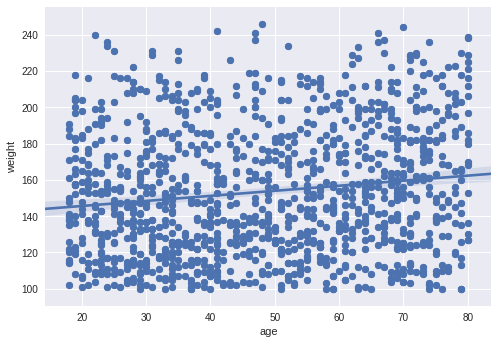

In [117]:
plt.scatter(df['age'],df['weight'])
sns.regplot(df['age'],df['weight'])

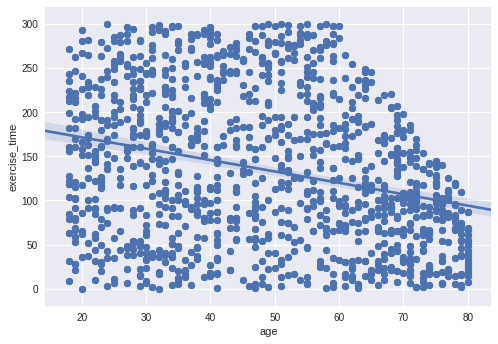

In [89]:
plt.scatter(df['age'],df['exercise_time'])
sns.regplot(df['age'],df['exercise_time'])

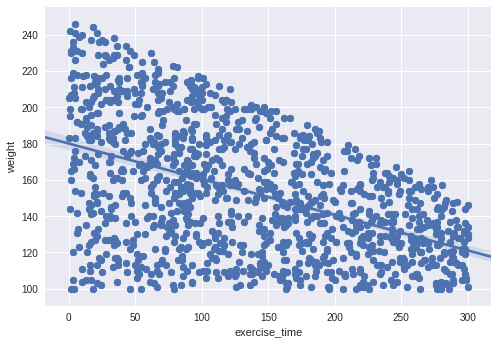

In [91]:
plt.scatter(df['exercise_time'],df['weight'])
sns.regplot(df['exercise_time'],df['weight'])

In [92]:
df.weight.mean()

153.54083333333332

In [0]:
def age_category(x):
  for i in x:

In [0]:
def f(x):
  #['18 to 30.', '30 to 42', '42 to 54', '54 to 68']
    val = []
    for i in x:
      if i > 54:
        val.append(4)
      elif i > 42:
        val.append(3)
      elif i > 30:
        val.append(2)
      else:
        val.append(1)
       
    return val


In [109]:
age_map = f(df['age'])
df['age_range'] = age_map
df.head()

,Unnamed: 0,age,weight,exercise_time,age_range
0,0,44,118,192,3
1,1,41,161,35,2
2,2,46,128,220,3
3,3,39,216,57,2
4,4,28,116,182,1


Text(0.5,1,'Minutes of Exercise by Age Range')

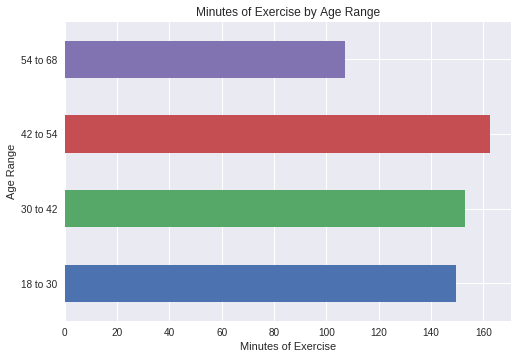

In [114]:
ax = df.groupby('age_range').exercise_time.mean().plot.barh()
ax.set_yticklabels(['18 to 30', '30 to 42', '42 to 54', '54 to 68'])
ax.set_xlabel('Minutes of Exercise')
ax.set_ylabel('Age Range')
ax.set_title('Minutes of Exercise by Age Range')

In [115]:
list(df)

['Unnamed: 0', 'age', 'weight', 'exercise_time', 'age_range']

Text(0.5,1,'Minutes of Exercise vs Weight by Age Range')

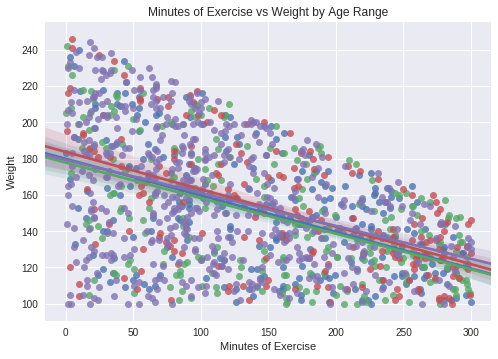

In [129]:
df1= df.loc[df['age_range'] == 1]
df2= df.loc[df['age_range'] == 2]
df3= df.loc[df['age_range'] == 3]
df4= df.loc[df['age_range'] == 4]

sns.regplot(df1['exercise_time'], df1['weight'])
sns.regplot(df2['exercise_time'], df2['weight'])
sns.regplot(df3['exercise_time'], df3['weight'])
sns.regplot(df4['exercise_time'], df4['weight'])
('Minutes of Exercise vs Weight by Age Range')
plt.xlabel('Minutes of Exercise')
plt.ylabel('Weight')
plt.title('Minutes of Exercise vs Weight by Age Range')


Text(0.5,1,'Average Weight by Age Range')

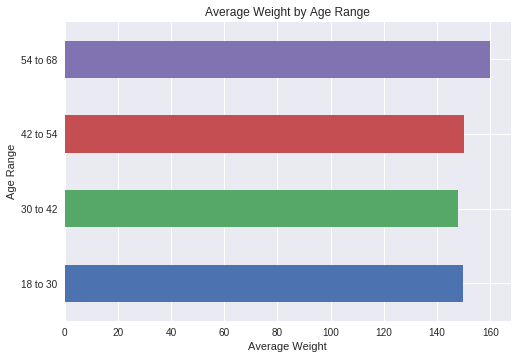

In [132]:
ax = df.groupby('age_range').weight.mean().plot.barh()
ax.set_yticklabels(['18 to 30', '30 to 42', '42 to 54', '54 to 68'])
ax.set_xlabel('Average Weight')
ax.set_ylabel('Age Range')
ax.set_title('Average Weight by Age Range')

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)